In [113]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from math import floor
import leidenalg as la
import igraph as ig
import csv
from read_roi import read_roi_file, read_roi_zip
from glob import glob
import os

In [114]:
class temporal_network:#object for creating node-aligned(every node exists every layer)
                       #with diagonal coupling(inter-layer edges exist only between node to itself)
        
    ##################################
    # TODO: extend omega(scalar) for vector and matrix
    ##################################
        
    def __init__(self, size, length, data, **kwargs):
        
        if length < 1: return('Object should be a multilayer network with at least 2 layers')
        if size < 3: return('Layers must have at least 3 nodes')
        
        self.size = size # number of nodes in every layer
        self.length = length # number of layers
        self.nodes = [i for i in range(self.size)]
        
        #### data: supra__adjacency, list_adjacency, edge_list
        
        ##         if supra__adjacency: creates the list adjacency matrix
        ##
        ##                     --- additional arguments ---
        ##                       - supra_adjacency: supra adjacency matrix of shape (size*time x size*time)
        
        
        ##
        ##         if edge__list: creates directed weighted multilayer network from the egde quadraplets
        ##                      given of the form (i,j,w,t). supra_adjacency and list_adjacency matrices 
        ##                      are automatically created. 
        ##
        ##                     --- additional arguments ---
        ##                       - edge_list: list of quadreplets e.g. [(0,2,w1,1),(2,1,w2,1),(0,1,w3,2),(0,2,w4,2)]
        ##                       - omega: interlayer coupling strength, can be a float only for now
        ##                       - kind: if ordinal, only adjacent layers gets connected with strength scalar 'omega'
        ##                               if cardinal, all layers get connected w/ each other w/ strength scalar 'omega'
        
        
        ##         if list__adjacency: creates the supra adjacency matrix from given list of adjacency matrices
        ##                             of monolayer networks
        ##                             TODO:add a warning to check if the adjacency matrices are node-aligned
        ##                      
        ##              
        ##                     --- additional arguments ---
        ##                       - list_adjacency: list of length 'length' that contains individual adjacency
        ##                                         matrices of each layer that are numpy arrays
        ##                       - omega: interlayer coupling strength, can be a float only for now
        ##                       - kind : if ordinal, only adjacent layers gets connected w/ strength scalar'omega'
        ##                                if cardinal, all layers get connected w/ each other w/ strength scalar'omega'
        ##
        ####
                    
        if  data == 'supra__adjacency':
            self.supra_adjacency = kwargs['supra_adjacency']
            list_adjacency = [ [] for i in range(length) ]
            
            for i in range(self.length):
                list_adjacency[i] = self.supra_adjacency[i*self.size:(i+1)*self.size,i*self.size:(i+1)*self.size]
            
            self.list_adjacency = list_adjacency
            
            edge_list = []
            for i in range(self.length):
                A = self.list_adjacency[i]
                firing = np.transpose(np.nonzero(A))
                for j,m in enumerate(firing):
                    quadreplet =(m[0],m[1],A[m[0],m[1]],i)
                    edge_list.append(quadreplet)
            self.edgelist = edge_list
                
        
        elif data == 'edge__list':
            self.edgelist = kwargs['edge_list']
            supra_adjacency = np.zeros((self.size*self.length,self.size*self.length))
            list_adjacency = [ [] for i in range(self.length) ]
            for q in range(self.length):
                list_adjacency[q]=np.zeros((self.size,self.size))
            
            for k,e in enumerate(self.edgelist):
                i,j,w,t = e[0], e[1], e[2],e[3]
                supra_adjacency[self.size*(t)+i][self.size*(t)+j] = w
                list_adjacency[t][i][j] = w

        
            ##filling off-diagonal blocks
            if kwargs['kind'] == 'ordinal':
                for n in range(self.size*(self.length-1)):
                    supra_adjacency[n][n+self.size] = kwargs['omega']
                    supra_adjacency[n+self.size][n] = kwargs['omega']
                
            elif kwargs['kind'] == 'cardinal':
                i = 0
                while self.length-i != 0:
                    i = i+1
                    for n in range(self.size*(self.length-i)):
                        supra_adjacency[n][n+i*self.size] = kwargs['omega']
                        supra_adjacency[n+i*self.size][n] = kwargs['omega']
            
            self.supra_adjacency = supra_adjacency
            self.list_adjacency = list_adjacency
            
        elif data == 'list__adjacency':
            self.list_adjacency = kwargs['list_adjacency']
            supra_adjacency = np.zeros((self.size*self.length,self.size*self.length))
            
            for i in range(self.length):
                supra_adjacency[i*self.size:(i+1)*self.size,i*self.size:(i+1)*self.size] = self.list_adjacency[i]
            
            ##filling off-diagonal blocks
            if kwargs['kind'] == 'ordinal':
                for n in range(self.size*(self.length-1)):
                    supra_adjacency[n][n+self.size] = kwargs['omega']
                    supra_adjacency[n+self.size][n] = kwargs['omega']
                
            elif kwargs['kind'] == 'cardinal':
                i = 0
                while self.length-i != 0:
                    i = i+1
                    for n in range(self.size*(self.length-i)):
                        supra_adjacency[n][n+i*self.size] = kwargs['omega']
                        supra_adjacency[n+i*self.size][n] = kwargs['omega']
            
            self.supra_adjacency = supra_adjacency
            
            edge_list = []
            for i in range(self.length):
                A = self.list_adjacency[i]
                firing = np.transpose(np.nonzero(A))
                for j,m in enumerate(firing):
                    quadreplet =(m[0],m[1],A[m[0],m[1]],i)
                    edge_list.append(quadreplet)
            self.edgelist = edge_list
            
    def aggragate(self, normalized = True):
        t = self.length
        n = self.size
        aggragated = np.zeros((n,n))
        
        for i,c in enumerate(self.list_adjacency):
            aggragated = aggragated + c
            
        if normalized: return (aggragated/t)
        else: return (aggragated)
            
    def modularity_matrix(self, omega, gamma):##TODO: fix modularity matrix
        N = self.size
        T = self.length
        B = np.zeros((N*T,N*T))
        two_mu = 0
        for i in range(T):
            k = np.sum(self.multi_array[i],0)
            two_m = np.sum(k,0)
            two_mu = two_mu + two_m
            B[i*N:(i+1)*N,i*N:(i+1)*N] = self.multi_array[i] - (gamma * k.T*k)/(two_m)
        two_mu = two_mu + 2*omega*N*(T-1)
        
        for p in range(N*(T-1)):
            B[p][p+N] = omega 
            B[p+N][p] = omega
            
        return(B)
    
    def edgelist2edges(self):
        T = self.length
        all_edges = [[] for i in range(T)]
        weights = []
        dtype = [('row',int),('column',int),('weight',float),('layer',int)]
        for k,e in enumerate(np.sort(np.array(self.edgelist, dtype=dtype),order='layer')):
            i,j,w,t = e[0], e[1], e[2],e[3]
            pair = (i,j)
            all_edges[t].append(pair)
            weights.append(w)
        return (all_edges, weights)
    
    def graph_formula(self):
        formula = '1'
        for i in range(2,self.length + 1):
            temp = formula
            formula = temp + ' -- %d'%i
        return(formula)
    
    def create_igraph(self, interslice):
        T = self.length
        N = self.size
        G = []
        edges = self.edgelist2edges()[0]
        weights = self.edgelist2edges()[1]
        for i in range(T):
            G.append(ig.Graph())
            G[i].add_vertices(N)
            G[i].add_edges(edges[i])
            G[i].es['weight'] = weights
            G[i].vs['id'] = list(range(N))
            G[i].vs['node_size'] = 0
            
        G_coupling = ig.Graph.Formula(self.graph_formula())
        G_coupling.es['weight'] = interslice # Interslice coupling strength
        G_coupling.vs['slice'] = G
        
        return(G)
    
    def layers(self, G, interslice):#returns: intralayer edges of each layer, interlayer edges and the full supra matrix
        layers, interslice_layer, G_full = la.time_slices_to_layers(G, interslice_weight = interslice)
        return(layers, interslice_layer, G_full)
    
    def leiden(self, G, interslice, resolution):
        
        layers, interslice_layer, G_full = self.layers(G,interslice)
        
        partitions = [la.CPMVertexPartition(H, 
                                            node_sizes = 'node_size',
                                            weights = 'weight', 
                                            resolution_parameter = resolution) for H in layers]
        
        interslice_partition = la.CPMVertexPartition(interslice_layer, 
                                                     resolution_parameter = resolution)
                                                     
        optimiser = la.Optimiser()
        
        diff = optimiser.optimise_partition_multiplex(partitions + [interslice_partition])

        return(diff, partitions, interslice_partition)
    
    def membership(self,interslice_partition):## returns the community assignments from the leiden algorithm as
        ##                                       tuple (n,t) n is the node id t is the layer that node is in
        n = self.size
        membership = [[] for i in range(interslice_partition._len)]
        for i,m in enumerate(interslice_partition._membership):
            time = floor(i/n)
            node_id = i%n
            membership[m].append((node_id,time))
        return(membership)

In [115]:
def normalized_cross_corr(x,y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    x_cov_std = np.nanmax(np.sqrt(np.correlate(x - x_mean, x - x_mean, 'full')))
    y_cov_std = np.nanmax(np.sqrt(np.correlate(y - y_mean, y - y_mean, 'full')))

    normalization = x_cov_std * y_cov_std
        

    unnormalized_correlation = np.correlate(x - x_mean, y - y_mean, 'full')
    
    corr_array = unnormalized_correlation/normalization

    return(corr_array)

def max_norm_cross_corr(x1, x2):
    
    correlation= normalized_cross_corr(x1, x2)
    
    lag = abs(correlation).argmax() - len(x1)+1
    
    max_corr = max(abs(correlation))
    
    return(max_corr, lag)

def cross_correlation_matrix(data):
    #input: n x t matrix where n is the number of rois and t is the duration of the time series
    #return: n x n symmetric cross correlation matrix, nxn uppertriangular cross correlation matrix and lag matrix
    n, t = data.shape
    X = np.zeros((n,n))
    lag = np.zeros((n,n))
    
    for i in range(n-1):
        for j in range(i+1,n):
            X[i][j],lag[i][j] = max_norm_cross_corr(data[i,:],data[j,:])
    X[np.isnan(X)] = 0
    lag[np.isnan(lag)] = 0
    
    X_full = X + X.T
    lag = lag + lag.T
    return(X_full, X, lag)

In [116]:
def read_csv(path, output, subject, roi, subject_roi):
    trace=open( path + output + subject + "_trace.csv", "r")
    spike=open( path + output + subject + "_spikes_complexity.csv", "r")
    reader_trace = csv.reader(trace)
    reader_spike = csv.reader(spike)
    n = read_roi(path, roi, subject_roi)
    traces = np.zeros((n,8000)) # roi x time
    spikes = np.zeros((n,8000)) # roi x time
    #row_count = sum(1 for row in reader)
    
    for i,line in enumerate(reader_trace):
        for j in range(len(line)):
            traces[i][j]=line[j]
    for i,line in enumerate(reader_spike):
        for j in range(len(line)):
            spikes[i][j]=line[j]
    return(traces, spikes)
            
def read_roi(path, roi, subject_roi):
    roi = read_roi_zip(glob(path+roi+subject_roi +'.zip')[0])
    n = len(roi)
    for i, R in enumerate(roi):
        x = roi[R]['x']
        y = roi[R]['y']
    return(n)

def bin_time_series(array, binsize, gaussian=True, **kwargs):
    binned_spikes = []
    for i in range(len(array)):
        A = array[i].reshape(binsize,int(8000/binsize))
        if gaussian:
            A = gaussian_filter(A,kwargs['sigma'])
        binned_spikes.append(A)
    return(np.array(binned_spikes))

def gaussian_filter(array,sigma):
    #sigma=0.25==gaussian kernel with length 3
    #sigma=0.5==gaussian kernel with length 5
    #sigma=1==gaussian kernel with length 9
    return(gaussian_filter1d(array,sigma))

In [117]:
path = '/Users/bengieru/MLN/data/' ## base path
output = 'Johan_Clean_Traces_Features_and_Spikes' #spikes and traces file
roi = 'sarah_ROI' #roi file
subject_roi = '/mouse_1_session_1_baseline' #subject
subject = '/m_1_session_1_baseline'# subject

In [118]:
time = 500 ## binning the time into chunks of
n = read_roi(path, roi, subject_roi) ## number of rois
t = int(8000/time) ## number of layers
traces, spikes = read_csv(path, output, subject, roi, subject_roi) #read the networks
binned_spikes = bin_time_series(spikes, time, gaussian = True, sigma=0.25) # bin the spikes into fixed length and apply gaussian kernel of length 3

In [119]:
##create cross-correlation matrices that are the adjacency matrices of the network at each layer
##create the same but uppertriangular cross correlation matrices for igraph
adjacency_matrices = []
upper_adjacency_matrices = []
for i in range(binned_spikes.shape[2]):
    adjacency_matrices.append(cross_correlation_matrix(binned_spikes[:,:,i])[0])
    upper_adjacency_matrices.append(cross_correlation_matrix(binned_spikes[:,:,i])[1])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


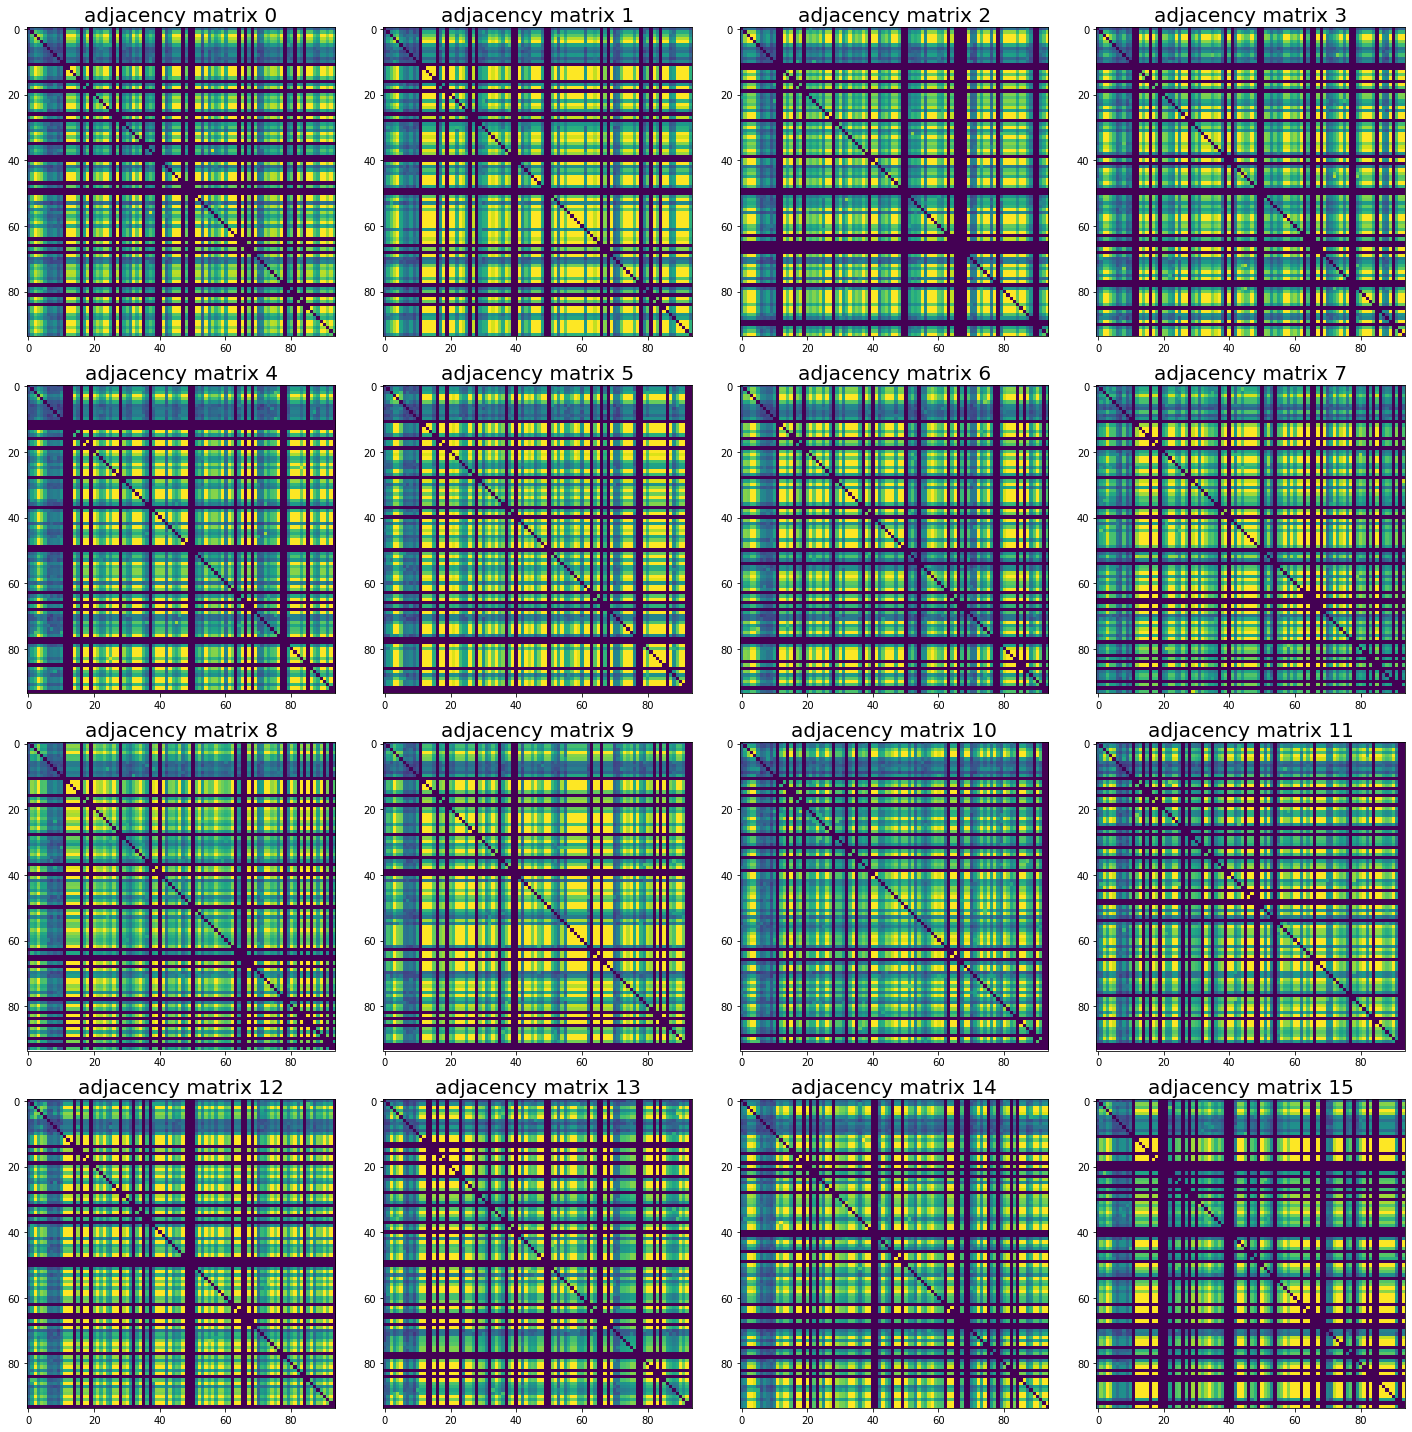

In [120]:
fig,ax=plt.subplots(4,4,figsize=(20,20))
for i in range(4):
    for j in range(4):
        ax[i][j].imshow(adjacency_matrices[i*4+j])
        ax[i][j].set_title('adjacency matrix %d'%(i*4+j),fontsize=20)
plt.tight_layout()

In [121]:
##TN- directed full temporal
##TNU- undirected full temporal
TN = temporal_network(n, t, data = 'list__adjacency', list_adjacency = adjacency_matrices, omega = 1, kind= 'ordinal')
TNU = temporal_network(n, t, data = 'list__adjacency', list_adjacency = upper_adjacency_matrices, omega = 1, kind= 'ordinal')

In [122]:
#TN.supra_adjacency,len(TN.list_adjacency),len(TN.edgelist)

In [123]:
igraphsU = TNU.create_igraph(1)
diffU, partsU, inter_partsU = TNU.leiden(igraphs,1,0)

In [161]:
##computing community sizes for varying interlayer coupling strengths and resolution parameters
resolutions = np.linspace(0,1,20)
comm_sizeU0 = []
comm_sizeU1 = []
comm_sizeU2 = []
comm_sizeU3 = []
comm_sizeU4 = []
for i in resolutions:
    diffU0, partsU0, inter_partsU0 = TNU.leiden(igraphs,0.1,i)
    c_sizeU0 = len(TNU.membership(inter_partsU0))
    comm_sizeU0.append(c_sizeU0)
    diffU1, partsU1, inter_partsU1 = TNU.leiden(igraphs,0.25,i)
    c_sizeU1 = len(TNU.membership(inter_partsU1))
    comm_sizeU1.append(c_sizeU1)
    diffU2, partsU2, inter_partsU2 = TNU.leiden(igraphs,0.5,i)
    c_sizeU2 = len(TNU.membership(inter_partsU2))
    comm_sizeU2.append(c_sizeU2)
    diffU3, partsU3, inter_partsU3 = TNU.leiden(igraphs,0.75,i)
    c_sizeU3 = len(TNU.membership(inter_partsU3))
    comm_sizeU3.append(c_sizeU3)
    diffU4, partsU4, inter_partsU4 = TNU.leiden(igraphs,1,i)
    c_sizeU4 = len(TNU.membership(inter_partsU4))
    comm_sizeU4.append(c_sizeU4)

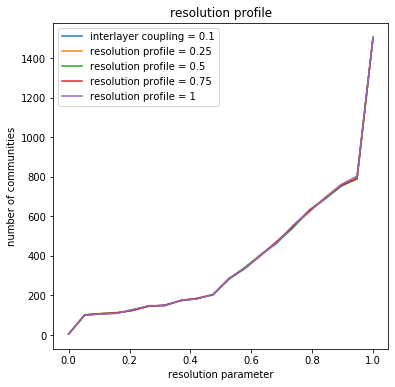

In [162]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
ax.plot(resolutions,comm_sizeU0,label='interlayer coupling = 0.1')
ax.plot(resolutions,comm_sizeU1,label='resolution profile = 0.25')
ax.plot(resolutions,comm_sizeU2,label='resolution profile = 0.5')
ax.plot(resolutions,comm_sizeU3,label='resolution profile = 0.75')
ax.plot(resolutions,comm_sizeU4,label='resolution profile = 1')

ax.set_title('resolution profile')
ax.set_xlabel('resolution parameter')
ax.set_ylabel('number of communities')

plt.legend()

In [125]:
#A=igraphs[0].get_adjacency(attribute='weight')
#B=igraphsU[0].get_adjacency(attribute='weight')

#fig,ax=plt.subplots(1,2,figsize=(10,10))
#ax[0].imshow(np.array(A.data))
#ax[1].imshow(np.array(adjacency_matrices[0]))

In [126]:
#dir(inter_partsU)
n=94
membership=[[] for i in range(inter_partsU._len)]
for i,m in enumerate(inter_partsU._membership):
    time = floor(i/n)
    node_id = i%n
    membership[m].append((node_id,time))

In [127]:
print(TN.layers(igraphs,1)[0][1])

IGRAPH U-W- 1504 6320 --
+ attr: id (v), node_size (v), slice (v), type (e), weight (e)
+ edges:
94--95 94--96 94--97 94--98 94--99 94--100 94--101 94--102 94--103 94--104
94--106 94--107 94--108 94--109 94--111 94--112 94--114 94--115 94--116
94--117 94--118 94--119 94--121 94--123 94--124 94--125 94--126 94--127
94--128 94--129 94--130 94--131 94--132 94--135 94--136 94--137 94--138
94--139 94--140 94--141 94--142 94--145 94--146 94--147 94--148 94--149
94--150 94--151 94--152 94--153 94--154 94--155 94--156 94--157 94--158
94--159 94--161 94--163 94--164 94--165 94--166 94--167 94--168 94--169
94--170 94--171 94--173 94--174 94--176 94--177 94--179 94--180 94--181
94--182 94--183 94--184 94--185 94--186 94--187 94--95 95--96 95--97 95--98
95--99 95--100 95--101 95--102 95--103 95--104 95--106 95--107 95--108 95--109
95--111 95--112 95--114 95--115 95--116 95--117 95--118 95--119 95--121
95--123 95--124 95--125 95--126 95--127 95--128 95--129 95--130 95--131
95--132 95--135 95--136 9